# Classify if the Gan-faces is wearing glasses or not

This project is to determine if a person is wearing glasses or not using data contianing all features. These features are generated from a Generative Adversarial Neural Network (GAN). The detailed information can refer to [here](https://www.kaggle.com/jeffheaton/glasses-or-no-glasses).
### Data
There are two data were used for this project: **(1)** training.csv, which include the 512 features one response variable glasses (1 represent have glass, 0 means no glasses). **(2)** submit.csv, which in fact is the test data which to measure how good of the model.

**Objetive**: To classify the data into two category use optmized netrual network with Bayesian optimization.

In [1]:
import pandas as pd
import os
import numpy as np
import time
import tensorflow.keras.initializers
import statistics
import tensorflow.keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import LeakyReLU,PReLU
from tensorflow.keras.optimizers import Adam

from scipy.stats import norm,kstest
from scipy import stats

In [ ]:
## if import kstest or shaprio give me problem, maybe try to downgrade your scipy
#!pip3 install --user scipy==1.2.0

## Import data

In [2]:
##train data
df_train = pd.read_csv("./data/train.csv",
                       na_values=['NA','?'])
df_train.drop('id',axis =1, inplace = True)

## submit data
df_submit = pd.read_csv("./data/test.csv",
                       na_values=['NA','?'])
ids = df_submit['id']
df_submit.drop('id',axis =1, inplace = True)
x_submit = df_submit.values


## Data exploration

In [3]:
df_train.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v504,v505,v506,v507,v508,v509,v510,v511,v512,glasses
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,...,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,0.029433,-0.072952,-0.063137,-0.027426,0.009050,-0.032587,0.005451,-0.101231,-0.134099,0.067560,...,-0.091886,0.057622,-0.063235,-0.081697,-0.032337,-0.084307,-0.032826,0.096038,-0.064696,0.634667
std,0.769812,0.740963,0.746607,0.744712,0.775853,0.770992,0.761690,0.748796,0.746005,0.747827,...,0.735644,0.739561,0.731691,0.761166,0.738119,0.743303,0.756891,0.737970,0.830538,0.481577
min,-2.895330,-2.381940,-2.599930,-2.748930,-2.291530,-4.020940,-2.736720,-2.872970,-2.397950,-2.768610,...,-2.788230,-2.624400,-2.806240,-2.907480,-3.136690,-2.490630,-2.510730,-2.626380,-2.906970,0.000000
25%,-0.489807,-0.568788,-0.575425,-0.548003,-0.541330,-0.550515,-0.516868,-0.582322,-0.658523,-0.455873,...,-0.537458,-0.445472,-0.546610,-0.601095,-0.506628,-0.605840,-0.546325,-0.373465,-0.615955,0.000000
50%,-0.001540,-0.097665,-0.053115,-0.058240,0.003175,-0.046450,0.005075,-0.097295,-0.149740,0.065725,...,-0.124335,0.034310,-0.045235,-0.103520,-0.038690,-0.099355,-0.032260,0.113235,-0.082685,1.000000
75%,0.507332,0.405330,0.458388,0.478182,0.555465,0.498605,0.506625,0.379340,0.377330,0.584847,...,0.370607,0.571075,0.438712,0.429145,0.459985,0.417492,0.495537,0.585468,0.469020,1.000000
max,2.518200,2.452530,3.637160,2.775740,3.247220,3.028140,2.761340,2.548660,2.384070,2.540040,...,2.954360,2.375880,2.641460,3.227290,2.654210,2.833950,2.632360,2.405620,2.827810,1.000000


### Check missing values

In [4]:
sum(df_train.isnull().sum()>0)
##if is zero means no missing vales

0

### Data type

In [5]:
col = list(df_train.columns)

unique_counts = pd.DataFrame.from_records([(col, df_train[col].nunique()) for col in df_train.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

unique_counts

,Column_Name,Num_Unique
512,glasses,2
462,v463,4434
309,v310,4436
371,v372,4439
447,v448,4440
...,...,...
418,v419,4471
81,v82,4471
256,v257,4471
463,v464,4472


From the above results, we can see all of predictors are numeric, only response is binary. 

### Normal distribution using Shapiro Wilk test

If the P-Value of the Shapiro Wilk Test is larger than 0.05, we assume a normal distribution
If the P-Value of the Shapiro Wilk Test is smaller than 0.05, we do not assume a normal distribution

More detailed information on normal distribution can be found 
https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93

In [15]:
def check_normal_distribution(df, cols):
    ks_results = []
    
    for col in cols:
        #ks_statistic, p_value = kstest(df[col],'norm')
        sw_statistic, p_value = stats.shapiro(df_train['v1'])
        re = [col,sw_statistic, p_value]
        ks_results.append(re)
        
    return ks_results

In [16]:
predictors = list(df_train.columns.values)
predictors.remove('glasses')

In [17]:
normal_test = pd.DataFrame(check_normal_distribution(df_train, cols = predictors),
                           columns=['features','sw_stat','p_values'])

In [18]:
normal_test[normal_test['p_values']>=0.01]

,features,sw_stat,p_values


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012990EF7C88>,
      dtype=object)

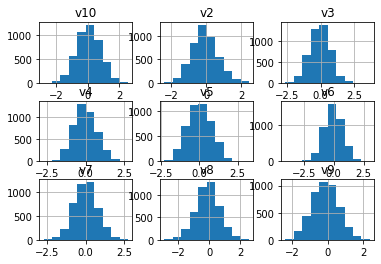

In [19]:
df_train[predictors[1:10]].hist()

Based on the SW test, all predictors are not normally distributed. But when I plot some of them, it look like they are normally distributed. Thus, let's first **not conduct normalization** for these predictors.

## Model building 

NN is what we want to use, but we don't how many layers should be included, the number of neurons and dropout will best for our analysis. Thus, the generate_model is mainly for this purpose.

In [20]:

def generate_model(dropout, neuronPct, neuronShrink,num_class,init_num_neurons = 4000):
    # We start with some percent of 5000 starting neurons on the first hidden layer.
    neuronCount = int(neuronPct * init_num_neurons)
    
    # Construct neural network
    # kernel_initializer = tensorflow.keras.initializers.he_uniform(seed=None)
    model = Sequential()

    # So long as there would have been at least 25 neurons and fewer than 10
    # layers, create a new layer.
    layer = 0
    while neuronCount>25 and layer<10:
        # The first (0th) layer needs an input input_dim(neuronCount)
        if layer==0:
            model.add(Dense(neuronCount, 
                input_dim=x.shape[1], 
                activation=PReLU()))
        else:
            model.add(Dense(neuronCount, activation=PReLU())) 
        layer += 1
        model.add(BatchNormalization())

        # Add dropout after each hidden layer
        model.add(Dropout(dropout))

        # Shrink neuron count for each layer
        neuronCount = neuronCount * neuronShrink
    if num_class>2:
         model.add(Dense(num_class,activation='softmax')) 
    else:
        model.add(Dense(num_class,activation='sigmoid')) # Output
    return model

One important step for Bayesian optimization is to define the optimized function. The following code is to define the loss for the model we define above.


In [21]:
def evaluate_network(dropout,lr,neuronPct,neuronShrink,num_class,training = True):
    SPLITS = 5

    # Bootstrap
    boot = StratifiedShuffleSplit(n_splits=SPLITS, test_size=0.2)

    # Track progress
    mean_benchmark = []
    epochs_needed = []
    num = 0
    
    sub_result = np.zeros((x_submit.shape[0],SPLITS))
    # Loop through samples
    for train, test in boot.split(x,y):
        start_time = time.time()
        num+=1

        # Split train and test
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]

        model = generate_model(dropout, neuronPct, neuronShrink,num_class)
        if num_class>2:
            model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr))
        else:
            model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr))
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=100, verbose=0, mode='auto', restore_best_weights=True)

        # Train on the bootstrap sample
        model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
        epochs = monitor.stopped_epoch
        epochs_needed.append(epochs)

        # Predict on the out of boot (validation)
        pred = model.predict(x_test)

        ## Predict on the submit data
        pred2 = model.predict(x_submit)[:,1]
        sub_result[:,(num - 1)] = pred2
        
        # Measure this bootstrap's log loss
        y_compare = np.argmax(y_test,axis=1) # For log loss calculation
        score = metrics.log_loss(y_compare, pred)
        mean_benchmark.append(score)
        m1 = statistics.mean(mean_benchmark)
        m2 = statistics.mean(epochs_needed)
        mdev = statistics.pstdev(mean_benchmark)

        # Record this iteration
        time_took = time.time() - start_time
        #print(f"#{num}: score={score:.6f}, mean score={m1:.6f}, stdev={mdev:.6f}, epochs={epochs}, mean epochs={int(m2)}, time={hms_string(time_took)}")

    tensorflow.keras.backend.clear_session()
    sub_mean = sub_result.mean(1)
    if training:
        return (-m1)
    else:
        return sub_mean


### Data preparation

In [23]:
names = list(df_train.columns) # x+y column names
names.remove("glasses")
num_class = df_train['glasses'].nunique()

In [25]:
x = df_train[names].values
dummies = pd.get_dummies(df_train['glasses']) # Classification
products = dummies.columns
y = dummies.values

In [53]:
##a simple test
re = evaluate_network(
    dropout=0.2,
    lr=1e-3,
    neuronPct=0.1,
    neuronShrink=0.3,
    num_class = 2,
    training = False)

## Bayesian optimization
* [bayesian-optimization](https://github.com/fmfn/BayesianOptimization)

Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not.

In [26]:
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings, see: https://stackoverflow.com/questions/34955158/what-might-be-the-cause-of-invalid-value-encountered-in-less-equal-in-numpy
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounded region of parameter space
pbounds = {'dropout': (0.0, 0.499),
           'lr': (0.0, 0.1),
           'neuronPct': (0.01, 1),
           'neuronShrink': (0.01, 1),
           'num_class':(2,2)
          }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=100,)
time_took = time.time() - start_time

print(f"Total runtime: {hms_string(time_took)}")
print(optimizer.max)

|   iter    |  target   |  dropout  |    lr     | neuronPct | neuron... | num_class |
-------------------------------------------------------------------------------------
|  1        | -0.01763  |  0.2081   |  0.07203  |  0.01011  |  0.3093   |  2.0      |
|  2        | -0.000452 |  0.04608  |  0.01863  |  0.3521   |  0.4028   |  2.0      |
|  3        | -0.000386 |  0.2092   |  0.06852  |  0.2124   |  0.8793   |  2.0      |
|  4        | -0.000461 |  0.3346   |  0.04173  |  0.5631   |  0.149    |  2.0      |
|  5        | -0.000206 |  0.3996   |  0.09683  |  0.3203   |  0.6954   |  2.0      |
|  6        | -0.002711 |  0.4464   |  0.008504 |  0.04866  |  0.1781   |  2.0      |
|  7        | -0.000611 |  0.04908  |  0.04211  |  0.9583   |  0.5378   |  2.0      |
|  8        | -0.000342 |  0.1574   |  0.06865  |  0.8363   |  0.02811  |  2.0      |
|  9        | -0.000458 |  0.4934   |  0.07482  |  0.2876   |  0.7914   |  2.0      |
|  10       | -0.000676 |  0.2235   |  0.09086  |  0.3

KeyboardInterrupt: 

In [27]:
optimizer.max['params']

{'dropout': 0.3995715397690928,
 'lr': 0.09682615757193976,
 'neuronPct': 0.3202899363776504,
 'neuronShrink': 0.6953993895126209,
 'num_class': 2.0}

In [28]:
final_re = evaluate_network(
    dropout=optimizer.max['params']['dropout'],
    lr=optimizer.max['params']['lr'],
    neuronPct=optimizer.max['params']['neuronPct'],
    neuronShrink=optimizer.max['params']['neuronShrink'],
    num_class = optimizer.max['params']['num_class'],
    training = False)

In [31]:
final_re.shape


(500,)